In [1]:
import os

In [2]:
import pretty_midi
import math
import itertools


In [44]:
import random

In [3]:
import numpy as np
import pickle
from collections import Counter
import re
import json

In [4]:
def walk(folder_name):
    files = []
    for p, d, f in os.walk(folder_name):
        for file_name in f:
            if file_name[-5:] == 'event':
                files.append(os.path.join(p,file_name))
    return files


In [207]:
pad = '<pad>'
eos = '<eos>'
mask = [f'm_{num}' for num in range(1)]
special_tokens = [pad, eos]

time_signature_token = ['4/4', '3/4', '2/4', '6/8']

program_num = [f'i_{num}' for num in range(128)]

tempo_token = [f't_{i}' for i in range(7)]

track_num = [f'track_{num}' for num in range(3)]

structure_token = ['bar'] + track_num


all_key_names = ['C major', 'G major', 'D major', 'A major',
                 'E major', 'B major', 'F major', 'B- major',
                 'E- major', 'A- major', 'D- major', 'G- major',
                 'A minor', 'E minor', 'B minor', 'F# minor',
                 'C# minor', 'G# minor', 'D minor', 'G minor',
                 'C minor', 'F minor', 'B- minor', 'E- minor',
                 ]

key_token = [f'k_{num}' for num in range(len(all_key_names))]
key_to_token = {name: f'k_{i}' for i, name in enumerate(all_key_names)}
token_to_key = {v: k for k, v in key_to_token.items()}

header_token = time_signature_token + tempo_token + program_num + key_token

track_note_density_token = [f'd_{num}' for num in range(10)]
track_occupation_rate_token = [f'o_{num}' for num in range(10)]
track_polyphony_rate_token = [f'y_{num}' for num in range(10)]
track_pitch_register_token = [f'r_{num}' for num in range(10)]

track_control_tokens = track_note_density_token + \
                       track_occupation_rate_token + \
                       track_polyphony_rate_token + \
                       track_pitch_register_token

tensile_strain_token = [f's_{num}' for num in range(12)]
diameter_token = [f'a_{num}' for num in range(12)]

bar_control_tokens = tensile_strain_token + diameter_token

control_tokens = []

rests = ['rest_e', 'rest_s']

durations = ['whole', 'half', 'quarter', 'eighth', 'sixteenth']

pitches = [f'p_{num}' for num in range(21, 109)] + rests + ['continue']

note_tokens = pitches + durations

all_tokens = special_tokens + mask + structure_token + \
             header_token + track_control_tokens + bar_control_tokens + \
             note_tokens

control_bins = np.arange(0, 1, 0.1)
# tensile_bins = np.arange(0, 2, 0.1).tolist() + np.arange(2, 2.8, 0.2).tolist() + [4]
tensile_bins = np.arange(0, 2.1, 0.2).tolist() + [4]
# diameter_bins = np.arange(0, 4.8, 0.2).tolist() + [5]
diameter_bins = np.arange(0, 4.1, 0.4).tolist() + [5]
tempo_bins = np.array([0] + list(range(60, 190, 30)) + [1000])

class WordVocab(object):
    def __init__(self, char_lst):
        super(WordVocab, self).__init__()
        self.pad_index = 0
        self.eos_index = 1
        self.char_lst = char_lst
        self._char2idx = {
            '<pad>': self.pad_index,
            '<eos>': self.eos_index,
        }

        for char in self.char_lst:
            if char not in self._char2idx:
                self._char2idx[char] = len(self._char2idx)
        self._idx2char = dict((idx, char) for char, idx in self._char2idx.items())
        print(f'vocab size: {self.vocab_size}')

        self.token_class_ranges = {}
        self.structure_indices = [self._char2idx[name] for name in structure_token]
        self.pitch_indices = [self._char2idx[name] for name in pitches]
        self.mask_indices = [self._char2idx[name] for name in mask]
        self.duration_indices = [self._char2idx[name] for name in durations + rests]
        self.key_indices = [self._char2idx[name] for name in key_token]
        self.density_indices = [self._char2idx[name] for name in track_note_density_token]
        self.occupation_indices = [self._char2idx[name] for name in track_occupation_rate_token]
        self.polyphony_indices = [self._char2idx[name] for name in track_polyphony_rate_token]
        self.pitch_register_indices = [self._char2idx[name] for name in track_pitch_register_token]
        self.program_indices = [self._char2idx[name] for name in program_num]
        self.tempo_indices = [self._char2idx[name] for name in tempo_token]
        self.time_signature_indices = [self._char2idx[name] for name in time_signature_token]
        self.tensile_indices = [self._char2idx[name] for name in tensile_strain_token]
        self.diameter_indices = [self._char2idx[name] for name in diameter_token]
        self.control_indices = self.key_indices + self.density_indices + self.occupation_indices + \
                               self.polyphony_indices + self.pitch_register_indices + self.tempo_indices + \
                               self.tensile_indices + self.diameter_indices + self.program_indices

        self.control_names = ['program','tempo','key','pitch_register',
                              'polyphony','density','occupation','tensile',
                              'diameter']
        for index in self.program_indices:
            self.token_class_ranges[index] = 'program'
        for index in self.tempo_indices:
            self.token_class_ranges[index] = 'tempo'
        for index in self.time_signature_indices:
            self.token_class_ranges[index] = 'time_signature'
        for index in self.key_indices:
            self.token_class_ranges[index] = 'key'
        for index in self.density_indices:
            self.token_class_ranges[index] = 'density'
        for index in self.occupation_indices:
            self.token_class_ranges[index] = 'occupation'
        for index in self.polyphony_indices:
            self.token_class_ranges[index] = 'polyphony'
        for index in self.pitch_register_indices:
            self.token_class_ranges[index] = 'pitch_register'


        for index in self.structure_indices:
            self.token_class_ranges[index] = 'structure'
        for index in self.pitch_indices:
            self.token_class_ranges[index] = 'pitch'
        for index in self.duration_indices:
            self.token_class_ranges[index] = 'duration'
        # for index in self.mask_indices:
        #     self.token_class_ranges[index] = 'mask'

        for index in self.tensile_indices:
            self.token_class_ranges[index] = 'tensile'
        for index in self.diameter_indices:
            self.token_class_ranges[index] = 'diameter'

        self.token_class_ranges[self.eos_index] = 'eos'
        self.class_names = set(self.token_class_ranges.values())


    def char2index(self, token):

        return self._char2idx.get(token)

    def index2char(self, idxs):

        return self._idx2char.get(idxs)

    def get_token_classes(self, idx):
        return self.token_class_ranges[idx]

    @property
    def vocab_size(self):
        return len(self._char2idx)

    def save_vocab(self, vocab_path):
        with open(vocab_path, "wb") as f:
            pickle.dump(self, f)

    @staticmethod
    def load_vocab(vocab_path: str) -> 'WordVocab':
        with open(vocab_path, "rb") as f:
            return pickle.load(f)

In [208]:
vocab = WordVocab(all_tokens)

vocab size: 330


In [5]:
V0=120
V1=100
V2=60

In [6]:
control_bins = np.arange(0, 1, 0.1)
# tensile_bins = np.arange(0, 2, 0.1).tolist() + np.arange(2, 2.8, 0.2).tolist() + [4]
tensile_bins = np.arange(0, 2.1, 0.2).tolist() + [4]
# diameter_bins = np.arange(0, 4.8, 0.2).tolist() + [5]
diameter_bins = np.arange(0, 4.1, 0.4).tolist() + [5]
tempo_bins = np.array([0] + list(range(60, 190, 30)) + [1000])

In [7]:
files = walk('../dataset/lmd/lmd_separate_event/')

In [10]:
total_bytes = 0
for file_name in files:
    total_bytes += os.path.getsize(file_name)

In [22]:
total_bytes/1024/1024

1188

In [20]:
len(files)

33028

In [24]:
1246047554/33028/1024

36

In [8]:
def tension_statistics(tensile,diameter):
    
    return np.max(tensile), np.max(diameter)

In [9]:
def note_density(track_events,track_length):
    
    densities = []
    tracks = track_events.keys()
    print(tracks)
    for track_name in tracks:
        #print(track_name)
        note_num = 0
        this_track_events = track_events[track_name]
        #print(this_track_events)
        for track_event in this_track_events:
            for event_index in range(len(track_event)-1):
                if track_event[event_index][0] == 'p' and track_event[event_index+1][0] != 'p':
                    note_num += 1
#         print(note_num / track_length)
        densities.append(note_num / track_length)
    return densities
        
    

In [10]:
def to_category(array,bins):
    result = []
    for item in array:
        result.append(int(np.where((item - bins) >= 0)[0][-1]))
    return result

In [11]:
def pitch_register(track_events):
    registers = []
    tracks = track_events.keys()
    # print(tracks)
    for track_name in tracks:
        # print(track_name)
        register = []
        this_track_events = track_events[track_name]
        # print(this_track_events)
        for track_event in this_track_events:
            for event in track_event:
                if event[0] == 'p':
                    register.append(int(event[2:]))
        #         print(note_num / track_length)
        # print(np.mean(register))
        registers.append(int(np.mean(register) / 21))
    return registers

In [13]:
def add_control_event(file_events,bar_pos,tensile,diameter,keys):
    num_of_tracks = len(file_events[3:np.where('track_0' == file_events)[0][0]])
#     print(f'number of bars is {len(bar_pos)}')
#     print(f'time signature is {file_event[1]}')
    bar_length = int(file_events[1][0])


    if bar_length != 6:
        bar_length = bar_length * 4 * len(bar_pos)
    else:
        bar_length = bar_length / 2 * 4 * len(bar_pos)
    #     print(f'bar length is {bar_length}')

    track_events = {}

    for i in range(num_of_tracks):
        track_events[f'track_{i}'] = []
    track_names = list(track_events.keys())
    for bar_index in range(len(bar_pos)-1):
        bar = bar_pos[bar_index]
        next_bar = bar_pos[bar_index+1]
        bar_events = file_events[bar:next_bar]
    #         print(bar_events)

        track_pos = []

        for track_name in track_names:
            track_pos.append(np.where(track_name == bar_events)[0][0])
    #         print(track_pos)
        for track_index in range(len(track_names)-1):
            track_event = bar_events[track_pos[track_index]:track_pos[track_index+1]]
            track_events[track_names[track_index]].append(track_event)
    #             print(track_event)
        else:
            track_index += 1
            track_event = bar_events[track_pos[track_index]:]
    #             print(track_event)
            track_events[track_names[track_index]].append(track_event)


    densities = note_density(track_events,bar_length)
    density_category = to_category(densities,control_bins)
    pm, _ = event_2midi(file_events.tolist())
    occupation_rate, polyphony_rate = occupation_polyphony_rate(pm)
    occupation_category = to_category(occupation_rate,control_bins)
    polyphony_category = to_category(polyphony_rate,control_bins)
    pitch_register_category = pitch_register(track_events)
    #     print(densities)
    #     print(occupation_rate)
    #     print(polyphony_rate)
    #     print(density_category)
    #     print(occupation_category)
    #     print(polyphony_category)

    #     key_token =  key_to_token[key]


    density_token = [f'd_{category}' for category in density_category]
    occupation_token = [f'o_{category}' for category in occupation_category]
    polyphony_token = [f'y_{category}' for category in polyphony_category]
    pitch_register_token = [f'r_{category}' for category in pitch_register_category]
    
    
    track_control_tokens = density_token + occupation_token + polyphony_token + pitch_register_token

    print(track_control_tokens)


    file_events = file_events.tolist()
    
    key = key_to_token[keys[0]]
    file_events.insert(3,key)
    
    if keys[2] != -1:
        changed_key_token = key_to_token[keys[3]]
    
    
    for token in track_control_tokens[::-1]:
        file_events.insert(4,token)

    tempo = float(file_events[2])
    tempo_category = int(np.where((tempo - tempo_bins) >= 0)[0][-1])
    file_events[2] = f't_{tempo_category}'


    tensile_category = to_category(tensiles,tensile_bins)
    diameter_category = to_category(diameters,diameter_bins)


    tension_positions = np.where(np.array(file_events) == 'track_0')[0]

    total_insert = 0
    for i,pos in enumerate(tension_positions):

        file_events.insert(pos + total_insert,f's_{tensile_category[i]}')
        total_insert += 1
        file_events.insert(pos + total_insert,f'a_{diameter_category[i]}')
        total_insert += 1
  
    return file_events,keys
        
    
    

In [90]:
added_event,keys = add_control_event(file_events,bar_pos,tensiles,diameters,keys)

dict_keys(['track_0', 'track_1', 'track_2'])
['d_1', 'd_1', 'd_3', 'o_7', 'o_8', 'o_5', 'y_0', 'y_0', 'y_9', 'r_3', 'r_1', 'r_2']


In [92]:
added_event

['bar',
 '4/4',
 't_1',
 'k_8',
 'd_1',
 'd_1',
 'd_3',
 'o_7',
 'o_8',
 'o_5',
 'y_0',
 'y_0',
 'y_9',
 'r_3',
 'r_1',
 'r_2',
 'i_88',
 'i_39',
 'i_2',
 's_4',
 'a_7',
 'track_0',
 'p_62',
 'eighth',
 'p_64',
 'eighth',
 'p_65',
 'eighth',
 'p_67',
 'sixteenth',
 'rest_e',
 'sixteenth',
 'p_71',
 'sixteenth',
 'rest_s',
 'p_69',
 'half',
 'track_1',
 'rest_e',
 'half',
 'p_38',
 'half',
 'track_2',
 'rest_e',
 'whole',
 'bar',
 's_1',
 'a_7',
 'track_0',
 'continue',
 'p_69',
 'quarter',
 'p_72',
 'eighth',
 'p_72',
 'quarter',
 'eighth',
 'p_70',
 'sixteenth',
 'rest_e',
 'sixteenth',
 'p_70',
 'eighth',
 'track_1',
 'continue',
 'p_38',
 'quarter',
 'p_30',
 'eighth',
 'sixteenth',
 'rest_e',
 'sixteenth',
 'p_31',
 'half',
 'track_2',
 'rest_e',
 'whole',
 'bar',
 's_3',
 'a_5',
 'track_0',
 'continue',
 'p_70',
 'quarter',
 'p_69',
 'sixteenth',
 'rest_e',
 'sixteenth',
 'p_67',
 'half',
 'eighth',
 'track_1',
 'continue',
 'p_31',
 'quarter',
 'p_38',
 'quarter',
 'p_36',
 'half

In [14]:
track_note_density_token = [f'd_{num}' for num in range(10)]
track_occupation_rate_token = [f'o_{num}' for num in range(10)]
track_polyphony_rate_token = [f'y_{num}' for num in range(10)]
track_pitch_register_token = [f'r_{num}' for num in range(10)]

tensile_strain_token = [f's_{num}' for num in range(24)]
diameter_token = [f'a_{num}' for num in range(24)]

all_key_names = ['C major','G major','D major','A major',
                 'E major','B major','F major','B- major',
                 'E- major','A- major','D- major','G- major',
                 'A minor','E minor', 'B minor','F# minor',
                 'C# minor','G# minor','D minor','G minor',
                 'C minor','F minor','B- minor','E- minor',
                 ]

key_token = [f'k_{num}' for num in range(len(all_key_names))]
key_to_token = {name:f'k_{i}' for i,name in enumerate(all_key_names)}
token_to_key = {v:k for k,v in key_to_token.items()}

In [217]:
note_density(track_events,1824)

0.4451754385964912
0.14473684210526316
0.28015350877192985


In [310]:
track_events,bar_length,_ = control_statistics(file_events,bar_pos)

104
3
4/4
1664
dict_keys(['track_0', 'track_1', 'track_2'])
[0.22235576923076922, 0.3425480769230769, 0.5889423076923077]
[0.6892059553349876, 0.6697360343769183, 0.6231527093596059]
[0.010801080108010801, 0.010999083409715857, 0.9456521739130435]


In [157]:
track_events['track_1'][0]

array(['track_1', 'rest_e', 'whole'], dtype='<U15')

In [15]:
time_signature_token = ['4/4', '3/4', '2/4', '6/8']

In [16]:
tension_folder = '/home/ruiguo/dataset/lmd/lmd_tension_three_tracks'


In [40]:
files[i]

'../dataset/lmd/lmd_separate_event/R/R/W/TRRRWOC128F42671E3/5b33e0d60257d60162ec502ab1ff6e2e_event'

In [17]:

with open('/home/ruiguo/dataset/lmd/lmd_tension_three_tracks/files_result.json','r') as key_file:
    key_data = json.load(key_file)

In [18]:
all_keys = list(key_data.values())

In [22]:
from collections import Counter
c = Counter()
for key in all_keys:
    c.update([key[0]])
c

Counter({'C major': 9728,
         'D major': 4897,
         'E major': 2879,
         'B- major': 4703,
         'G- major': 1578,
         'E- major': 3686,
         'F major': 7078,
         'D- major': 2418,
         'A major': 4481,
         'G major': 6174,
         'A- major': 3392,
         'B major': 1705,
         'F# minor': 101,
         'E minor': 405,
         'B- minor': 329,
         'D minor': 760,
         'A minor': 759,
         'C minor': 496,
         'G minor': 285,
         'B minor': 241,
         'C# minor': 131,
         'E- minor': 98,
         'F minor': 188,
         'G# minor': 227})

In [41]:
keys = key_data[tension_folder + file_name_in_folder + '.mid']

array(['bar', '4/4', '84.00008400008399', ..., 'sixteenth', 'rest_e',
       'sixteenth'], dtype='<U17')

In [26]:
all_tensiles = []
all_diameters = []

i = 2

#     print(f'file name is {files[i]}')
file_events = np.array(pickle.load(open(files[i], 'rb')))

#     print(file_events)
time_signature = file_events[2]

file_name_in_folder = files[i].split('lmd_separate_event')[1:][0][:-6]
tensile_file = tension_folder + file_name_in_folder + '.tensile'
diameter_file = tension_folder + file_name_in_folder + '.diameter'

tensiles = np.array(pickle.load(open(tensile_file, 'rb')))
diameters =  np.array(pickle.load(open(diameter_file, 'rb')))

keys = key_data[tension_folder + file_name_in_folder + '.mid']


bar_pos = np.where(file_events == 'bar')[0]

total_bars = min(len(tensiles), len(diameters), len(bar_pos))
if total_bars < len(bar_pos):
    bar_pos = bar_pos[:total_bars+1]
    file_events = file_events[:bar_pos[-1]]
    bar_pos = bar_pos[:-1]

#     print(total_bars)

#     num_bars = print(len(bar_pos))

added_file_events,keys = add_control_event(file_events,bar_pos,tensiles,diameters,keys)
#     max_tensile,max_diameter = tension_statistics(tensile,diameter)
#     if max_tensile == 0:
#         print(f'0 tensile, file name is {files[i]}')
#         continue
#     if max_diameter == 0:
#         print(f'0 diameter, file name is {files[i]}')
#         continue

#     max_tensiles.append(max_tensile)
#     max_diameters.append(max_diameter)

assert len(tensiles)  == len(bar_pos), print(files[i],i)
assert len(diameters)  == len(bar_pos), print(files[i])
all_tensiles.append(tensiles)
all_diameters.append(diameters)
        
    
#     print(max_tensile,max_diameter)

    
    
    

dict_keys(['track_0', 'track_1', 'track_2'])
['d_1', 'd_1', 'd_3', 'o_7', 'o_8', 'o_5', 'y_0', 'y_0', 'y_9', 'r_3', 'r_1', 'r_2']


In [114]:
for event in file_events:
    print(event,end=', ')

bar, 4/4, 84.00008400008399, i_88, i_39, i_2, track_0, p_62, eighth, p_64, eighth, p_65, eighth, p_67, sixteenth, rest_e, sixteenth, p_71, sixteenth, rest_s, p_69, half, track_1, rest_e, half, p_38, half, track_2, rest_e, whole, bar, track_0, continue, p_69, quarter, p_72, eighth, p_72, quarter, eighth, p_70, sixteenth, rest_e, sixteenth, p_70, eighth, track_1, continue, p_38, quarter, p_30, eighth, sixteenth, rest_e, sixteenth, p_31, half, track_2, rest_e, whole, bar, track_0, continue, p_70, quarter, p_69, sixteenth, rest_e, sixteenth, p_67, half, eighth, track_1, continue, p_31, quarter, p_38, quarter, p_36, half, track_2, rest_e, whole, bar, track_0, continue, p_67, quarter, p_62, eighth, p_70, quarter, eighth, p_69, sixteenth, rest_e, sixteenth, p_69, eighth, track_1, continue, p_36, quarter, p_28, quarter, p_29, half, track_2, rest_e, whole, bar, track_0, continue, p_69, quarter, p_67, sixteenth, rest_e, sixteenth, p_69, half, eighth, track_1, continue, p_29, eighth, sixteenth, r

In [31]:
for event in added_file_events:
    print(event,end=', ')

bar, 4/4, t_1, k_8, d_1, d_1, d_3, o_7, o_8, o_5, y_0, y_0, y_9, r_3, r_1, r_2, i_88, i_39, i_2, s_4, a_7, track_0, p_62, eighth, p_64, eighth, p_65, eighth, p_67, sixteenth, rest_e, sixteenth, p_71, sixteenth, rest_s, p_69, half, track_1, rest_e, half, p_38, half, track_2, rest_e, whole, bar, s_1, a_7, track_0, continue, p_69, quarter, p_72, eighth, p_72, quarter, eighth, p_70, sixteenth, rest_e, sixteenth, p_70, eighth, track_1, continue, p_38, quarter, p_30, eighth, sixteenth, rest_e, sixteenth, p_31, half, track_2, rest_e, whole, bar, s_3, a_5, track_0, continue, p_70, quarter, p_69, sixteenth, rest_e, sixteenth, p_67, half, eighth, track_1, continue, p_31, quarter, p_38, quarter, p_36, half, track_2, rest_e, whole, bar, s_3, a_6, track_0, continue, p_67, quarter, p_62, eighth, p_70, quarter, eighth, p_69, sixteenth, rest_e, sixteenth, p_69, eighth, track_1, continue, p_36, quarter, p_28, quarter, p_29, half, track_2, rest_e, whole, bar, s_5, a_10, track_0, continue, p_69, quarter,

In [36]:
r = re.compile('i_\d')

track_program = list(filter(r.match, added_file_events))[0]

In [141]:
track_program

['i_88', 'i_39', 'i_2']

In [ ]:
track_num = len(track_program)
if track_num == 3:
    ratios = [.5,.25,.25]
    track_0_pos = np.where('track_0' == np.array(added_file_events))[0]
    track_1_pos = np.where('track_1' == np.array(added_file_events))[0]
    track_2_pos = np.where('track_2' == np.array(added_file_events))[0]
    all_track_pos = np.sort(np.concatenate([track_0_pos,track_1_pos,track_2_pos]))
    
else:
    ratios = [.5,.5]
    track_0_pos = np.where('track_0' == np.array(added_file_events))[0]
    track_1_pos = np.where('track_1' == np.array(added_file_events))[0]
    all_track_pos = np.sort(np.concatenate([track_0_pos,track_1_pos]).sort())
    


In [68]:
bar_pos = np.where('bar' == np.array(added_file_events))[0]

In [69]:
bar_pos

array([   0,   45,   77,  102,  131,  163,  199,  225,  263,  327,  384,
        456,  518,  582,  639,  709,  773,  855,  900,  964, 1014, 1068,
       1113])

In [118]:
bar_start_index = np.random.choice(len(bar_pos))
if bar_start_index == len(bar_pos) - 1:
    next_bar_start_index = len(added_file_events)
else:
    next_bar_start_index = bar_start_index + 1 

In [120]:
bar_start_pos = bar_pos[bar_start_index]
next_bar_start_pos = bar_pos[next_bar_start_index]

In [132]:
bar_start_pos

964

In [133]:
next_bar_start_pos

1014

In [123]:
track_start_index = np.where(all_track_pos > bar_start_pos)[0][0]

In [130]:
track_positions = all_track_pos[track_start_index:track_start_index+track_num]

In [131]:
track_positions

array([967, 970, 978])

In [135]:
next_bar_start_pos

1014

In [140]:
track_positions = np.append(track_positions,next_bar_start_pos)

In [142]:
track_positions

array([ 967,  970,  978, 1014])

In [192]:
prob = random.random()
print(prob)
if prob < ratios[0]:
    # select one track
    #
    track_pos_select_index = [np.random.choice(track_num)]
elif prob < ratios[0] + ratios[1]:
    # select two tracks
    track_pos_select_index = np.sort(np.random.choice(track_num,2,replace=False))
else:
    # select three tracks
    track_pos_select_index = np.arange(track_num)
    


0.17380254273721896


In [193]:
track_pos_select_index

[2]

In [194]:
track_positions[track_pos_index]

978

In [197]:
masked_indices_pairs = []

In [198]:
for track_pos_index in track_pos_select_index:
    track_start_pos = track_positions[track_pos_index]
    c = track_positions[track_pos_index+1]
    print(track_start_pos)
    print(track_end_pos)
    track_event = added_file_events[track_start_pos:track_end_pos]
    print(track_event)
    masked_indices_pairs.append((track_start_pos,track_end_pos))
    

978
1014
['track_2', 'rest_e', 'eighth', 'p_48', 'p_60', 'p_64', 'p_67', 'quarter', 'p_60', 'p_62', 'p_65', 'p_70', 'quarter', 'rest_s', 'p_41', 'half', 'rest_s', 'quarter', 'p_60', 'eighth', 'sixteenth', 'rest_s', 'p_65', 'p_69', 'quarter', 'rest_s', 'eighth', 'sixteenth', 'p_38', 'p_60', 'sixteenth', 'p_40', 'p_62', 'p_66', 'p_69', 'eighth']


In [199]:
masked_indices_pairs

[(978, 1014)]

In [200]:
start_pos = 0

In [206]:
vocab

NameError: name 'vocab' is not defined

In [231]:
token_events = added_file_events.copy()
tokens = []
decoder_in = []
decoder_target = []
for masked_pairs in masked_indices_pairs:
    masked_token = added_file_events[masked_pairs[0]:masked_pairs[1]]
    print(masked_token)
    decoder_in.append(vocab.mask_indices[0])
    for token in masked_token:
        decoder_in.append(vocab.char2index(token))
        decoder_target.append(vocab.char2index(token))
    else:
        decoder_target.append(vocab.eos_index)
for masked_pairs in masked_indices_pairs[::-1]:
    print(masked_pairs)
    print(token_events[masked_pairs[0]:masked_pairs[1]])
    for pop_time in range(masked_pairs[1]-masked_pairs[0]):
        print(token_events.pop(masked_pairs[0]))
    token_events.insert(masked_pairs[0],mask[0])
    
for token in token_events:
    tokens.append(vocab.char2index(token))
                                    

#     print(tokens[masked_pairs[0]-10:])

# print()

['track_2', 'rest_e', 'eighth', 'p_48', 'p_60', 'p_64', 'p_67', 'quarter', 'p_60', 'p_62', 'p_65', 'p_70', 'quarter', 'rest_s', 'p_41', 'half', 'rest_s', 'quarter', 'p_60', 'eighth', 'sixteenth', 'rest_s', 'p_65', 'p_69', 'quarter', 'rest_s', 'eighth', 'sixteenth', 'p_38', 'p_60', 'sixteenth', 'p_40', 'p_62', 'p_66', 'p_69', 'eighth']
(978, 1014)
['track_2', 'rest_e', 'eighth', 'p_48', 'p_60', 'p_64', 'p_67', 'quarter', 'p_60', 'p_62', 'p_65', 'p_70', 'quarter', 'rest_s', 'p_41', 'half', 'rest_s', 'quarter', 'p_60', 'eighth', 'sixteenth', 'rest_s', 'p_65', 'p_69', 'quarter', 'rest_s', 'eighth', 'sixteenth', 'p_38', 'p_60', 'sixteenth', 'p_40', 'p_62', 'p_66', 'p_69', 'eighth']
track_2
rest_e
eighth
p_48
p_60
p_64
p_67
quarter
p_60
p_62
p_65
p_70
quarter
rest_s
p_41
half
rest_s
quarter
p_60
eighth
sixteenth
rest_s
p_65
p_69
quarter
rest_s
eighth
sixteenth
p_38
p_60
sixteenth
p_40
p_62
p_66
p_69
eighth


In [221]:
tokens

['bar',
 '4/4',
 't_1',
 'k_8',
 'd_1',
 'd_1',
 'd_3',
 'o_7',
 'o_8',
 'o_5',
 'y_0',
 'y_0',
 'y_9',
 'r_3',
 'r_1',
 'r_2',
 'i_88',
 'i_39',
 'i_2',
 's_4',
 'a_7',
 'track_0',
 'p_62',
 'eighth',
 'p_64',
 'eighth',
 'p_65',
 'eighth',
 'p_67',
 'sixteenth',
 'rest_e',
 'sixteenth',
 'p_71',
 'sixteenth',
 'rest_s',
 'p_69',
 'half',
 'track_1',
 'rest_e',
 'half',
 'p_38',
 'half',
 'track_2',
 'rest_e',
 'whole',
 'bar',
 's_1',
 'a_7',
 'track_0',
 'continue',
 'p_69',
 'quarter',
 'p_72',
 'eighth',
 'p_72',
 'quarter',
 'eighth',
 'p_70',
 'sixteenth',
 'rest_e',
 'sixteenth',
 'p_70',
 'eighth',
 'track_1',
 'continue',
 'p_38',
 'quarter',
 'p_30',
 'eighth',
 'sixteenth',
 'rest_e',
 'sixteenth',
 'p_31',
 'half',
 'track_2',
 'rest_e',
 'whole',
 'bar',
 's_3',
 'a_5',
 'track_0',
 'continue',
 'p_70',
 'quarter',
 'p_69',
 'sixteenth',
 'rest_e',
 'sixteenth',
 'p_67',
 'half',
 'eighth',
 'track_1',
 'continue',
 'p_31',
 'quarter',
 'p_38',
 'quarter',
 'p_36',
 'half

In [217]:
masked_pairs[1]-masked_pairs[0]

36

In [215]:
tokens[masked_pairs[0]:masked_pairs[1]]

['track_2',
 'rest_e',
 'eighth',
 'p_48',
 'p_60',
 'p_64',
 'p_67',
 'quarter',
 'p_60',
 'p_62',
 'p_65',
 'p_70',
 'quarter',
 'rest_s',
 'p_41',
 'half',
 'rest_s',
 'quarter',
 'p_60',
 'eighth',
 'sixteenth',
 'rest_s',
 'p_65',
 'p_69',
 'quarter',
 'rest_s',
 'eighth',
 'sixteenth',
 'p_38',
 'p_60',
 'sixteenth',
 'p_40',
 'p_62',
 'p_66',
 'p_69',
 'eighth']

In [213]:
masked_pairs

(978, 1014)

In [170]:
track_positions[:track_num]

array([967, 970, 978])

In [169]:
np.sort(np.random.choice(track_num,2,replace=False))

array([0, 2])

In [167]:
track_positions[:track_num]

array([967, 970, 978])

In [166]:
np.sort(np.random.choice(track_num,2,replace=False))

array([0, 1])

In [96]:
bar_num

23

In [ ]:
bar_num

In [92]:
track_num*bar_num

69

In [95]:
len(all_track_pos)

69

In [99]:
bar_num_selected

5

In [98]:
all_track_pos[track_num*bar_num_selected]

166

In [97]:
bar_num = len(bar_pos)

In [81]:
bar_num

23

In [ ]:
all_track_pos

In [86]:
bar_num_selected = random.randint(0,bar_num-1)

In [87]:
bar_pos_selected = bar_pos[bar_num_selected]

In [88]:
bar_pos_selected

163

In [47]:
prob = random.random()

In [ ]:
if len(track_program) == 3:
    if prob < ratios[0]:
        #mask one track in a bar
        mask_track_pos = np.random.choice(all_track_pos)
        

In [ ]:




program_start_pos = np.where(track_0_program == np.array(event_list))[0][0]

start_track_pos = np.where('track_0' == np.array(event_list))[0][0]
programs = event_list[program_start_pos:start_track_pos]

In [27]:
added_file_events

['bar',
 '4/4',
 't_1',
 'k_8',
 'd_1',
 'd_1',
 'd_3',
 'o_7',
 'o_8',
 'o_5',
 'y_0',
 'y_0',
 'y_9',
 'r_3',
 'r_1',
 'r_2',
 'i_88',
 'i_39',
 'i_2',
 's_4',
 'a_7',
 'track_0',
 'p_62',
 'eighth',
 'p_64',
 'eighth',
 'p_65',
 'eighth',
 'p_67',
 'sixteenth',
 'rest_e',
 'sixteenth',
 'p_71',
 'sixteenth',
 'rest_s',
 'p_69',
 'half',
 'track_1',
 'rest_e',
 'half',
 'p_38',
 'half',
 'track_2',
 'rest_e',
 'whole',
 'bar',
 's_1',
 'a_7',
 'track_0',
 'continue',
 'p_69',
 'quarter',
 'p_72',
 'eighth',
 'p_72',
 'quarter',
 'eighth',
 'p_70',
 'sixteenth',
 'rest_e',
 'sixteenth',
 'p_70',
 'eighth',
 'track_1',
 'continue',
 'p_38',
 'quarter',
 'p_30',
 'eighth',
 'sixteenth',
 'rest_e',
 'sixteenth',
 'p_31',
 'half',
 'track_2',
 'rest_e',
 'whole',
 'bar',
 's_3',
 'a_5',
 'track_0',
 'continue',
 'p_70',
 'quarter',
 'p_69',
 'sixteenth',
 'rest_e',
 'sixteenth',
 'p_67',
 'half',
 'eighth',
 'track_1',
 'continue',
 'p_31',
 'quarter',
 'p_38',
 'quarter',
 'p_36',
 'half

In [28]:
bar_pos = np.where(np.array(added_file_events) == 'bar')[0]

In [29]:
bar_pos

array([   0,   45,   77,  102,  131,  163,  199,  225,  263,  327,  384,
        456,  518,  582,  639,  709,  773,  855,  900,  964, 1014, 1068,
       1113])

In [30]:
added_file_events[45]

'bar'

In [152]:
all_tensiles = np.array(all_tensiles,dtype=float)

ValueError: setting an array element with a sequence.

In [156]:
all_tensiles.shape

(32352,)

In [149]:
tensile_bins

array([0. , 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ,
       2.1, 2.2, 2.4, 2.6, 2.8, 5. ])

In [18]:
max_tensiles = np.array(max_tensiles)
max_diameters = np.array(max_diameters)

In [19]:
max_tensiles.max()

3.8924019274376067

In [360]:
max_diameters.max()

4.621688003316537

In [335]:
max_tensiles

array([1.15156805, 1.32252445, 1.02725396, ..., 0.86007819, 2.75349387,
       1.45386565])

In [347]:
hist,bin_edges = np.histogram(max_tensiles)

In [348]:
bin_edges

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
np.arange(0.5,3.5,0.1)

array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7,
       1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. ,
       3.1, 3.2, 3.3, 3.4])

In [27]:
tensile_bins = [0] + np.arange(0.9,2.3,0.1).tolist() +  np.arange(2.4,2.9,0.2).tolist() + [5]

In [159]:
np.concatenate(all_tensiles).shape

(3297477,)

In [181]:
tensile_bins = np.arange(0,2,0.1).tolist() + np.arange(2,2.8,0.2).tolist() + [4]

(array([119299.,  77539., 199627., 368677., 357933., 336245., 325451.,
        344184., 368882., 274570., 169576., 113835.,  79284.,  57171.,
         33708.,  18654.,  10076.,  10751.,   7274.,   4699.,   7622.,
          4757.,   3426.,   4237.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.2, 2.4, 2.6, 4. ]),
 <BarContainer object of 24 artists>)

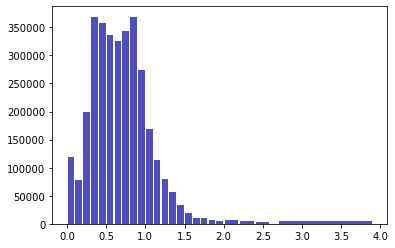

In [182]:
plt.hist(x=np.concatenate(all_tensiles), bins=tensile_bins, color='#0504aa',alpha=0.7, rwidth=0.85)

In [177]:
diameter_bins = np.arange(0,4.8,0.2).tolist() + [5]

(array([394490.,  70975.,  79202.,  81209.,  95927., 110586., 129896.,
        189577., 237582., 576008., 404518., 184072., 114220.,  74161.,
         63904.,  73688.,  51410.,  42928.,  41959., 121052.,  56311.,
         31092.,  24435.,  48275.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4,
        2.6, 2.8, 3. , 3.2, 3.4, 3.6, 3.8, 4. , 4.2, 4.4, 4.6, 5. ]),
 <BarContainer object of 24 artists>)

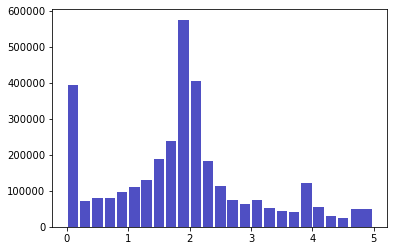

In [178]:
plt.hist(x=np.concatenate(all_diameters), bins=diameter_bins, color='#0504aa',alpha=0.7, rwidth=0.85)

In [88]:
diameter_bins = [0] + np.arange(2,4.8,0.2).tolist() + [5]

In [90]:
def tensile_to_event_name(tensile,bins):
    

    return


def diameter_to_event_name(diameter,bins):
    return

In [84]:
np.sum(max_diameters == max_diameters.max())

6158

(array([1757., 1857., 2292., 2205., 1727., 1463., 2114., 1193., 1147.,
        1172., 3293., 1977., 1834., 1794., 6497.]),
 array([0. , 2. , 2.2, 2.4, 2.6, 2.8, 3. , 3.2, 3.4, 3.6, 3.8, 4. , 4.2,
        4.4, 4.6, 5. ]),
 <BarContainer object of 15 artists>)

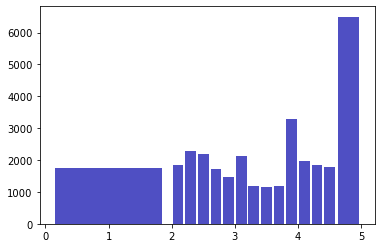

In [85]:
plt.hist(x=max_diameters, bins=bins, color='#0504aa',alpha=0.7, rwidth=0.85)

In [86]:
file_events

array(['bar', '4/4', '125.0', 'i_62', 'i_5', 'i_33', 'track_0', 'rest_e',
       'whole', 'track_1', 'rest_e', 'whole', 'track_2', 'rest_e',
       'whole', 'bar', 'track_0', 'rest_e', 'whole', 'track_1', 'p42',
       'whole', 'track_2', 'rest_e', 'whole', 'bar', 'track_0', 'rest_e',
       'whole', 'track_1', 'p47', 'whole', 'track_2', 'rest_e', 'whole',
       'bar', 'track_0', 'rest_e', 'whole', 'track_1', 'p50', 'whole',
       'track_2', 'rest_e', 'whole', 'bar', 'track_0', 'rest_e', 'whole',
       'track_1', 'p49', 'whole', 'track_2', 'rest_e', 'whole', 'bar',
       'track_0', 'rest_e', 'whole', 'track_1', 'continue', 'p49',
       'sixteenth', 'p42', 'half', 'quarter', 'eighth', 'sixteenth',
       'track_2', 'rest_e', 'sixteenth', 'p30', 'sixteenth', 'rest_e',
       'sixteenth', 'p42', 'sixteenth', 'rest_e', 'sixteenth', 'p30',
       'sixteenth', 'rest_e', 'sixteenth', 'p42', 'sixteenth', 'rest_e',
       'sixteenth', 'p30', 'sixteenth', 'rest_e', 'sixteenth', 'p42',
     

In [29]:
for event in file_events:
    print(event)

bar
4/4
113.00073450477427
i_96
i_39
i_24
track_0
rest_e
whole
track_1
rest_e
whole
track_2
rest_e
whole
bar
track_0
rest_e
whole
track_1
rest_e
whole
track_2
rest_e
whole
bar
track_0
rest_e
whole
track_1
rest_e
whole
track_2
p_52
whole
rest_s
eighth
p_59
half
quarter
eighth
rest_s
eighth
p_64
half
quarter
rest_s
eighth
p_66
eighth
p_68
half
bar
track_0
p_56
sixteenth
rest_s
p_56
eighth
rest_e
sixteenth
p_56
sixteenth
p_56
sixteenth
p_56
sixteenth
rest_e
sixteenth
p_56
sixteenth
p_56
eighth
rest_e
sixteenth
p_56
sixteenth
p_59
eighth
p_57
sixteenth
p_56
sixteenth
track_1
rest_e
whole
track_2
continue
p_52
continue
p_59
half
quarter
eighth
rest_s
continue
p_64
eighth
sixteenth
rest_s
continue
p_68
half
quarter
eighth
sixteenth
rest_e
sixteenth
bar
track_0
continue
p_56
sixteenth
p_54
half
quarter
eighth
sixteenth
track_1
rest_e
whole
track_2
rest_e
eighth
sixteenth
p_54
half
quarter
sixteenth
rest_s
sixteenth
p_57
quarter
rest_s
sixteenth
p_61
eighth
sixteenth
rest_s
sixteenth
p_66
sixt

p_64
sixteenth
rest_e
sixteenth
bar
track_0
continue
p_61
quarter
eighth
rest_e
eighth
p_66
eighth
p_66
sixteenth
p_68
eighth
p_68
eighth
rest_e
sixteenth
track_1
p_42
sixteenth
rest_e
eighth
p_37
eighth
sixteenth
p_40
eighth
p_42
sixteenth
rest_e
eighth
p_37
eighth
sixteenth
p_42
eighth
track_2
p_54
p_57
p_61
p_64
sixteenth
rest_e
sixteenth
p_54
p_61
sixteenth
p_57
p_64
p_61
p_54
sixteenth
rest_e
sixteenth
p_54
p_57
p_61
p_64
sixteenth
p_54
p_64
p_61
p_57
sixteenth
rest_e
sixteenth
p_61
p_64
p_54
p_57
sixteenth
rest_e
eighth
p_61
p_64
p_54
p_57
sixteenth
rest_e
sixteenth
p_61
p_54
p_57
p_64
sixteenth
p_54
p_64
p_57
p_61
sixteenth
rest_e
sixteenth
bar
track_0
p_64
sixteenth
rest_e
sixteenth
p_64
sixteenth
p_64
eighth
p_63
eighth
p_64
sixteenth
p_66
half
track_1
p_37
sixteenth
rest_e
eighth
p_32
eighth
sixteenth
p_37
eighth
p_35
sixteenth
rest_e
eighth
p_35
eighth
rest_e
sixteenth
p_30
eighth
track_2
p_56
p_64
p_59
p_61
sixteenth
rest_e
eighth
p_64
p_56
p_59
p_61
sixteenth
rest_e
sixtee

sixteenth
rest_e
quarter
sixteenth
p_64
eighth
track_1
p_40
sixteenth
rest_e
eighth
p_35
eighth
sixteenth
p_37
eighth
p_40
sixteenth
rest_e
eighth
p_35
eighth
p_37
sixteenth
p_40
eighth
track_2
p_59
p_64
p_52
p_56
sixteenth
rest_e
sixteenth
p_59
sixteenth
p_52
p_56
p_59
p_64
sixteenth
rest_e
sixteenth
p_59
p_64
p_56
sixteenth
p_64
p_56
p_59
p_52
sixteenth
rest_e
sixteenth
p_52
p_56
p_64
p_59
sixteenth
rest_e
sixteenth
p_52
p_59
p_64
sixteenth
p_59
p_52
p_64
p_56
sixteenth
rest_e
sixteenth
p_56
p_59
p_64
p_52
sixteenth
p_56
p_64
p_59
sixteenth
rest_s
p_52
eighth
bar
track_0
p_61
quarter
eighth
p_64
eighth
p_63
eighth
sixteenth
p_64
eighth
sixteenth
p_66
eighth
track_1
p_42
eighth
rest_e
sixteenth
p_37
eighth
sixteenth
p_42
eighth
p_35
sixteenth
rest_e
eighth
p_30
eighth
sixteenth
p_35
eighth
track_2
p_64
p_54
p_61
p_57
sixteenth
rest_e
sixteenth
p_61
p_57
sixteenth
p_57
p_64
p_61
p_54
sixteenth
rest_e
sixteenth
p_61
p_57
p_54
p_64
sixteenth
p_54
p_64
p_57
p_61
sixteenth
rest_e
sixteenth

In [25]:
def event_2midi(event_list):

    event_list = filter_empty_bars(event_list)

    # file1 = open("MyFile.txt", "w")
    # for i in range(len(event_list)-1):
    #     event = event_list[i]
    #     next_event = event_list[i+1]
    #     file1.write(event)
    #     file1.write(', ')
    #     if next_event == 'bar':
    #         file1.write('\n')
    #     if next_event == 'track':
    #         file1.write(' ')
    # file1.close()

    counts = Counter(event_list)

    event_names = list(counts.keys())

    tempo = float(event_names[2])
    pm_new = pretty_midi.PrettyMIDI(initial_tempo=tempo)

    numerator = int(event_names[1].split('/')[0])
    denominator = int(event_names[1].split('/')[1])
    time_signature = pretty_midi.TimeSignature(numerator, denominator, 0)
    pm_new.time_signature_changes = [time_signature]



    r = re.compile('i_\d')

    track_0_program = list(filter(r.match, event_names))[0]



    program_start_pos = np.where(track_0_program == np.array(event_list))[0][0]

    start_track_pos = np.where('track_0' == np.array(event_list))[0][0]
    programs = event_list[program_start_pos:start_track_pos]



    for track in programs:
        track = pretty_midi.Instrument(program=int(track.split('_')[-1]))
        pm_new.instruments.append(track)


    # add a fake note for duration dict calculation
    pm_new.instruments[0].notes.append(pretty_midi.Note(
        velocity=100, pitch=30, start=0, end=10))
    beats = pm_new.get_beats()
    pm_new.instruments[0].notes.pop()
    duration_name_to_time,duration_time_to_name,duration_times,bar_duration = get_note_duration_dict(beats[1]-beats[0],(time_signature.numerator,time_signature.denominator))

    curr_time = 0
    previous_bar_start_time = 0
    previous_duration = 0

    in_duration_event = False
    is_rest_s = False
    is_continue = False

    pitch_list = []
    duration_list = []

    bar_num = 0
    track = 0


    sta_dict_list = []
    track_bar_length = []
    track_bar_pitch_length = []
    for _ in programs:
        sta_dict_list.append({'duration_token_length':[],'bar_length':[], 'pitch_token_length':[]})
        track_bar_length.append(0)
        track_bar_pitch_length.append(0)


    def total_duration(duration_list):
        total = 0
        if duration_list:

            for duration in duration_list:
                total += duration_name_to_time[duration]
        return total

    def clear_pitch_duration_event(pm_new,
                                    track,
                                   curr_time,
                                   previous_duration,
                                   is_rest_s,
                                   is_continue,
                                   pitch_list,
                                   duration_list):
        if is_rest_s:
            duration = total_duration(duration_list)
            curr_time -= previous_duration

        else:
            duration = total_duration(duration_list)


        for pitch in pitch_list:
            if is_continue:
                # look for the previous note, and change the end time of it
                for note in pm_new.instruments[track].notes[::-1]:
                    if note.end == curr_time and note.pitch == pitch:
                        note.end += duration
                        break

            else:
                if track == 0:
                    velocity = V0
                elif track == 1:
                    velocity = V1
                else:
                    velocity = V2
                note = pretty_midi.Note(velocity=velocity,pitch=pitch,start=curr_time,
                    end=curr_time + duration)
                pm_new.instruments[track].notes.append(note)

        curr_time += duration
        previous_duration = duration

        return curr_time,previous_duration


    for i, event in enumerate([event_list[0]] + event_list[start_track_pos:]):



        if event in duration_name_to_time.keys():
            duration_list.append(event)
            in_duration_event = True

            track_bar_length[track] += 1

            continue

        if in_duration_event:

            sta_dict_list[track]['duration_token_length'].append(len(duration_list))

            curr_time, previous_duration = clear_pitch_duration_event(pm_new,
                                                                      track,
                                                                      curr_time,
                                                                      previous_duration,
                                                                      is_rest_s,
                                                                      is_continue,
                                                                      pitch_list,
                                                                      duration_list)
            pitch_list = []
            duration_list = []

            in_duration_event = False
            is_rest_s = False
            is_continue = False


        pitch_match = re.search(r'p_(\d+)', event)
        if pitch_match:

            track_bar_pitch_length[track] += 1

            pitch = int(pitch_match.group(1))
            pitch_list.append(pitch)

        if event == 'rest_s':
            is_rest_s = True

        if event == 'continue':
            is_continue = True


        if event == 'bar':
            bar_start_time = bar_num * bar_duration
            bar_num += 1

            if bar_num != 1:

                for i in range(len(programs)):
                    sta_dict_list[i]['bar_length'].append(track_bar_length[i])
                    sta_dict_list[i]['pitch_token_length'].append(track_bar_pitch_length[i])
                    track_bar_length[i] = track_bar_pitch_length[i] = 0

            # if bar_num == 57:
            #     logger.info(bar_num)

            # validate previous bar total time

            if not math.isclose(bar_start_time,curr_time):
                logger.info(f'in bar {bar_num} the total duration does not equal bar duration')
                exit(1)
            continue


        track_match = re.search(r'track_(\d)', event)

        if track_match:
            curr_time = bar_start_time
            previous_duration = 0
            track = int(track_match.group(1))

        track_bar_length[track] += 1

    else:

        for i in range(len(programs)):
            sta_dict_list[i]['bar_length'].append(track_bar_length[i])
            sta_dict_list[i]['pitch_token_length'].append(track_bar_pitch_length[i])
            track_bar_length[i] = track_bar_pitch_length[i] = 0

    return pm_new, sta_dict_list


In [21]:
def filter_empty_bars(events):
    bar_num = 0
    filled_bar = 0
    first_track_num = 0

    for pos,event in enumerate(events):
        if event == 'bar':
            bar_num += 1
            bar_pos = pos
        if event == 'track_0':
            if first_track_num == 0:
                first_track_num = pos
        if event[0] == 'p':
            filled_bar = bar_num

            break

    if filled_bar != 1:
        meta_events = events[:first_track_num]

        return meta_events + events[bar_pos+1:]
    else:
        return events

In [22]:
def get_note_duration_dict(beat_duration,curr_time_signature):
    duration_name_to_time = {}
    if curr_time_signature[1] == 4:
        # 4/4, 2/4, 3/4
        quarter_note_duration = beat_duration
        half_note_duration = quarter_note_duration * 2
        eighth_note_duration = quarter_note_duration / 2
        sixteenth_note_duration = quarter_note_duration / 4
        # quarter_triplets_duration = half_note_duration / 3
        # eighth_triplets_duration = quarter_note_duration / 3
        # sixteenth_triplets_duration = eighth_note_duration / 3
        if curr_time_signature[0] >= 4:
            whole_note_duration = 4 * quarter_note_duration
        bar_duration = curr_time_signature[0] * quarter_note_duration

    else:
        # 6/8

        quarter_note_duration = beat_duration / 3 * 2
        half_note_duration = quarter_note_duration * 2
        eighth_note_duration = quarter_note_duration / 2
        sixteenth_note_duration = quarter_note_duration / 4
        # quarter_triplets_duration = half_note_duration / 3
        # eighth_triplets_duration = quarter_note_duration / 3
        # sixteenth_triplets_duration = eighth_note_duration / 3

        bar_duration = curr_time_signature[0] * eighth_note_duration

    duration_name_to_time['half'] = half_note_duration
    duration_name_to_time['quarter'] = quarter_note_duration
    duration_name_to_time['eighth'] = eighth_note_duration
    duration_name_to_time['sixteenth'] = sixteenth_note_duration

    basic_names = duration_name_to_time.keys()
    name_pairs = itertools.combinations(basic_names, 2)
    name_triple = itertools.combinations(basic_names, 3)
    name_quadruple = itertools.combinations(basic_names, 4)

    for name1,name2 in name_pairs:
        duration_name_to_time[name1+'_'+name2] = duration_name_to_time[name1] + duration_name_to_time[name2]

    for name1, name2,name3 in name_triple:
        duration_name_to_time[name1 + '_' + name2 + '_' + name3] = duration_name_to_time[name1] + duration_name_to_time[name2] + duration_name_to_time[name3]

    for name1, name2, name3, name4 in name_quadruple:
        duration_name_to_time[name1 + '_' + name2 + '_' + name3 + '_' + name4] = duration_name_to_time[name1] + duration_name_to_time[
            name2] + duration_name_to_time[name3] + duration_name_to_time[name4]


    duration_name_to_time['zero'] = 0

    # duration_name_to_time['quarter_triplets'] = quarter_triplets_duration
    # duration_name_to_time['eighth_triplets'] = eighth_triplets_duration
    # duration_name_to_time['sixteenth_triplets'] = sixteenth_triplets_duration

    if curr_time_signature[0] >= 4 and curr_time_signature[1] == 4:
        duration_name_to_time['whole'] = whole_note_duration

    duration_time_to_name = {v: k for k, v in duration_name_to_time.items()}

    duration_times = np.sort(np.array(list(duration_time_to_name.keys())))
    return duration_name_to_time,duration_time_to_name,duration_times,bar_duration


In [23]:
def occupation_polyphony_rate(pm):
    occupation_rate = []
    polyphony_rate = []
    beats = pm.get_beats()
    fs = 4/(beats[1] - beats[0])
    
    for instrument in pm.instruments:
        piano_roll = instrument.get_piano_roll(fs = fs)
        occupation_rate.append(np.count_nonzero(np.any(piano_roll, 0)) / piano_roll.shape[1])
        polyphony_rate.append(np.count_nonzero(np.count_nonzero(piano_roll, 0) > 1) / np.count_nonzero(np.any(piano_roll, 0)))
        
    return occupation_rate,polyphony_rate

In [68]:
file_name = files[2]

In [69]:
file_name

'../dataset/lmd/lmd_separate_event/R/R/A/TRRRAJP128E0793859/2c78d25cb52eb48f767186ddaf11b191_event'

In [70]:
file_events = np.array(pickle.load(open(file_name, 'rb')))

In [71]:
file_events

array(['bar', '4/4', '84.00008400008399', ..., 'sixteenth', 'rest_e',
       'sixteenth'], dtype='<U17')

In [73]:
pm_new, sta_dict_list = event_2midi(file_events.tolist())

In [75]:
occupation_polyphony_rate(pm_new)

([0.7955390334572491, 0.8201634877384196, 0.5367847411444142],
 [0.018691588785046728, 0.016611295681063124, 0.9543147208121827])

In [272]:
piano_roll = pm_new.instruments[0].get_piano_roll(fs = fs)

In [273]:
np.count_nonzero(np.count_nonzero(piano_roll, 0) > 1) / np.count_nonzero(np.any(piano_roll, 0))

0.010801080108010801

In [264]:
np.count_nonzero(np.any(piano_roll, 0)) / piano_roll.shape[1]

0.6892059553349876

### tensile statistics

In [53]:
min(len(tensile),len(diameter),len(bar_pos))

69

In [52]:
total_bars

70

In [49]:
len(tensile)

69

In [50]:
len(diameter)

69

In [51]:
len(bar_pos)

70

In [47]:
min(len(tensile),len(diameter),len(bar_pos))

69

In [58]:
np.max(tensile)

1.4538656539446826

## bar event validator

In [104]:
rests = ['rest_e', 'rest_s']

In [106]:
durations = ['whole', 'half', 'quarter', 'eighth', 'sixteenth']

pitches = [f'p_{num}' for num in range(21, 109)] + rests + ['continue']

note_tokens = pitches + durations

In [110]:
events

['bar',
 's_1',
 'a_7',
 'track_0',
 'continue',
 'p_69',
 'quarter',
 'p_72',
 'eighth',
 'p_72',
 'quarter',
 'eighth',
 'p_70',
 'sixteenth',
 'rest_e',
 'sixteenth',
 'p_70',
 'eighth',
 'track_1',
 'continue',
 'p_38',
 'quarter',
 'p_30',
 'eighth',
 'sixteenth',
 'rest_e',
 'sixteenth',
 'p_31',
 'half',
 'track_2',
 'rest_e',
 'whole',
 'bar',
 's_3',
 'a_5',
 'track_0',
 'continue',
 'p_70',
 'quarter',
 'p_69',
 'sixteenth',
 'rest_e',
 'sixteenth',
 'p_67',
 'half',
 'eighth',
 'track_1',
 'continue',
 'p_31',
 'quarter',
 'p_38',
 'quarter',
 'p_36',
 'half',
 'track_2',
 'rest_e',
 'whole',
 'bar',
 's_3',
 'a_6',
 'track_0',
 'continue',
 'p_67',
 'quarter',
 'p_62',
 'eighth',
 'p_70',
 'quarter',
 'eighth',
 'p_69',
 'sixteenth',
 'rest_e',
 'sixteenth',
 'p_69',
 'eighth',
 'track_1',
 'continue',
 'p_36',
 'quarter',
 'p_28',
 'quarter',
 'p_29',
 'half',
 'track_2',
 'rest_e',
 'whole',
 'bar',
 's_5',
 'a_10',
 'track_0',
 'continue',
 'p_69',
 'quarter',
 'p_67',
 

In [93]:
added_event

['bar',
 '4/4',
 't_1',
 'k_8',
 'd_1',
 'd_1',
 'd_3',
 'o_7',
 'o_8',
 'o_5',
 'y_0',
 'y_0',
 'y_9',
 'r_3',
 'r_1',
 'r_2',
 'i_88',
 'i_39',
 'i_2',
 's_4',
 'a_7',
 'track_0',
 'p_62',
 'eighth',
 'p_64',
 'eighth',
 'p_65',
 'eighth',
 'p_67',
 'sixteenth',
 'rest_e',
 'sixteenth',
 'p_71',
 'sixteenth',
 'rest_s',
 'p_69',
 'half',
 'track_1',
 'rest_e',
 'half',
 'p_38',
 'half',
 'track_2',
 'rest_e',
 'whole',
 'bar',
 's_1',
 'a_7',
 'track_0',
 'continue',
 'p_69',
 'quarter',
 'p_72',
 'eighth',
 'p_72',
 'quarter',
 'eighth',
 'p_70',
 'sixteenth',
 'rest_e',
 'sixteenth',
 'p_70',
 'eighth',
 'track_1',
 'continue',
 'p_38',
 'quarter',
 'p_30',
 'eighth',
 'sixteenth',
 'rest_e',
 'sixteenth',
 'p_31',
 'half',
 'track_2',
 'rest_e',
 'whole',
 'bar',
 's_3',
 'a_5',
 'track_0',
 'continue',
 'p_70',
 'quarter',
 'p_69',
 'sixteenth',
 'rest_e',
 'sixteenth',
 'p_67',
 'half',
 'eighth',
 'track_1',
 'continue',
 'p_31',
 'quarter',
 'p_38',
 'quarter',
 'p_36',
 'half

In [97]:
bar_pos = np.where(np.array(added_event) == 'bar')[0]

In [98]:
bar_pos

array([   0,   45,   77,  102,  131,  163,  199,  225,  263,  327,  384,
        456,  518,  582,  639,  709,  773,  855,  900,  964, 1014, 1068,
       1113])

In [99]:
events = added_event[bar_pos[1]:]

In [103]:
assert events[0] == 'bar'
assert events[1][0] == 's'
assert events[2][0] == 'a'
assert events[3] == 'track_0'


In [108]:
in_track = True

In [107]:
assert events[4] in pitches

until the end of this track generation

In [109]:
duration_list = []
if event in durations:
    in_duration = True
    duration_list.append(event)
    

In [ ]:
def check_duration(duration_list):
    

In [ ]:
if event in pitches and in_duration:
    
    duration_list

In [237]:
from scipy.stats import norm

In [238]:
x = np.linspace(norm.ppf(0.01),
                norm.ppf(0.99), 100)

<IPython.core.display.Javascript object>


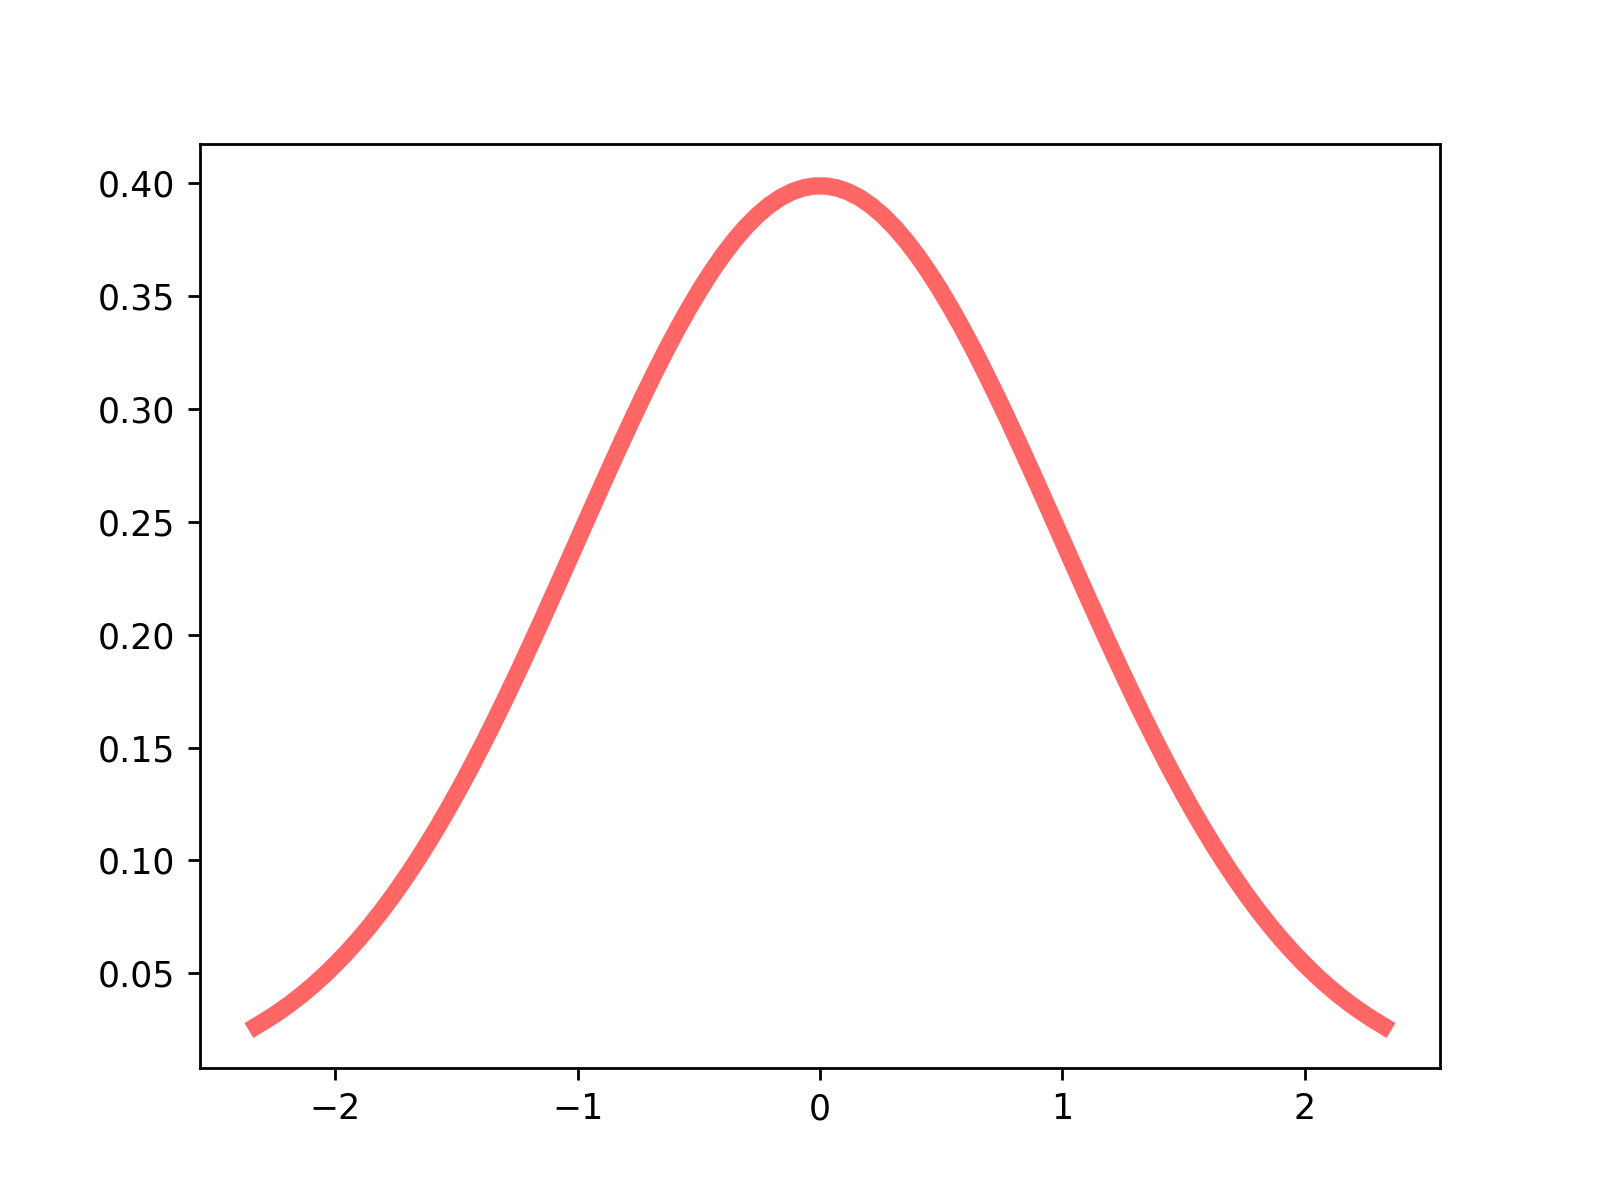

In [244]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

In [242]:
%matplotlib notebook

In [245]:
ax.plot(x, norm.pdf(x),
       'r-', lw=5, alpha=0.6, label='norm pdf')

In [246]:
x

array([-2.32634787, -2.27935095, -2.23235402, -2.18535709, -2.13836017,
       -2.09136324, -2.04436631, -1.99736939, -1.95037246, -1.90337553,
       -1.85637861, -1.80938168, -1.76238475, -1.71538783, -1.6683909 ,
       -1.62139397, -1.57439705, -1.52740012, -1.48040319, -1.43340627,
       -1.38640934, -1.33941241, -1.29241549, -1.24541856, -1.19842163,
       -1.15142471, -1.10442778, -1.05743085, -1.01043393, -0.963437  ,
       -0.91644007, -0.86944314, -0.82244622, -0.77544929, -0.72845236,
       -0.68145544, -0.63445851, -0.58746158, -0.54046466, -0.49346773,
       -0.4464708 , -0.39947388, -0.35247695, -0.30548002, -0.2584831 ,
       -0.21148617, -0.16448924, -0.11749232, -0.07049539, -0.02349846,
        0.02349846,  0.07049539,  0.11749232,  0.16448924,  0.21148617,
        0.2584831 ,  0.30548002,  0.35247695,  0.39947388,  0.4464708 ,
        0.49346773,  0.54046466,  0.58746158,  0.63445851,  0.68145544,
        0.72845236,  0.77544929,  0.82244622,  0.86944314,  0.91

In [247]:
norm.ppf(0.01)

-2.3263478740408408

In [248]:
ratio = [0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.05,0.05,0.05,0.05,0.05,0.05]

In [249]:
sum(ratio)

1.0000000000000004